In [1]:
import numpy as np  
import math
from enum import Enum
from collections import namedtuple

# matplotlib
# ライブラリーのインポート
import matplotlib.pyplot as plt
# インライン表示
%matplotlib inline
# 日本語フォント
import pylab
from matplotlib.font_manager import FontProperties

# ipynbのインポート
import nbimporter
from common_data import get_calendar

Importing Jupyter notebook from common_data.ipynb


# 家電機器

## 14.　アイロン（ver自立P4）

### 14.1　定義

#### 14.1.1　機器の電源接続状態および動作状態

アイロンの電源接続状態および動作状態は、以下を想定する。

* 使用時：AC電源に接続され、動作状態は稼働となる。
* 非使用時：電源から切断され、動作状態は停止となる。    

#### 14.1.2　機器の機能等

アイロンが有する機能は、以下を想定する。  

* 機能：
    * アイロン：主機能である。稼働時に作動する。

想定する状態および機能に対応する添え字は以下のとおりである。なお、単機能であるため、機能に対応する添え字は省略する。  

|居住者による使用状態 |機器の電源接続状態 |機器の動作状態 |機器の機能 |添え字 |備考  　　　|  
|:-------------------:|:-----------------:|:-------------:|:---------:|:-----:|:----------:|    
|使用                 |AC電源接続         |稼働           |アイロン   |opg    |-     　　　|  
|非使用               |電源切断　         |停止           |-          |-　    |消費電力ゼロ|  

### 14.2　消費電力量

日付$d$の時刻$t$におけるアイロンの消費電力量$E_{E,Iron,d,t}$は、式(1)により表される。

$$ 
\begin{equation*}
    E_{E,Iron,d,t} = E_{E,opg,d,t} 
\end{equation*}
$$


<div style="text-align: right;"> (1) </div>

ここで、  

$E_{E,Iron,d,t}$：日付$d$の時刻$t$におけるアイロンの単位時間当たりの消費電力量[Wh]  
$E_{E,opg,d,t}$：日付$d$の時刻$t$における稼働時の単位時間当たりの消費電力量[Wh]  

である。

In [2]:
def EE_app (EE_opg):
    '''消費電力量[Wh]を計算する'''
    # EE_opg：稼働時の消費電力量[Wh]
    
    return EE_opg

日付$d$の時刻$t$における稼働時の消費電力量は、式(2)により計算される。

* 稼働時の消費電力量：  
$$ 
\begin{equation*}
    E_{E,opg,d,t} = P_{opg} \times dt_{opg,d,t} \div 3600
\end{equation*}
$$


<div style="text-align: right;"> (2) </div>

ただし、式(3)を満たす。
$$ 
\begin{equation*}
    dt_{opg,d,t} \leq dt_{calc}
\end{equation*}
$$
<div style="text-align: right;"> (3) </div>

ここで、  

$dt_{calc}$：単位時間[s]   
$dt_{opg,d,t}$：日付$d$の時刻$t$における稼働時間の合計[s]  
$E_{E,opg,d,t}$：日付$d$の時刻$t$における稼働時の単位時間当たりの消費電力量[Wh]   
$P_{opg}$：1時間当たりの稼働時の平均消費電力[W] 

である。

In [3]:
def EE_opg (dt_opg, P_opg):
    '''稼働時の消費電力量[Wh]を計算する'''
    # dt_opg：稼働時間の合計[s]
    # P_opg：稼働時の消費電力[W]
    
    return dt_opg * P_opg / 3600

In [4]:
def check_duration (dt):
    '''合計が単位時間を超過しないか否かを確認する'''
    # dt：稼働時間の合計[s](list型)
    
    # dt_calc：単位時間[s]
    dt_calc = 3600.
    
    # 継続時間を積算する
    dt_sum = sum(dt)
    
    # エラーチェック
    if dt_calc < dt_sum:
        # 単位時間を超える場合 => エラー
        try:
            raise Exception('機器使用スケジュールに不正があります。')
        except Exception:
            raise
    else:
        pass

### 14.3　稼働時の消費電力

日付$d$の時刻$t$における稼働時の消費電力は、式(4)により計算される。

* 稼働時の消費電力： 
$$ 
\begin{equation*}
    P_{opg} = 0.53 \times P_{rtd,opg} 
\end{equation*}
$$


<div style="text-align: right;"> (4) </div>

ここで、   

$P_{opg}$：1時間当たりの稼働時の平均消費電力[W]  
$P_{rtd,opg}$：定格消費電力[W]  

である。

In [5]:
def P_opg (Prtd_opg):
    '''稼働時の消費電力[W]を計算する''' 
    # Prtd_opg：稼働時の消費電力[W]
    
    return 0.53 * Prtd_opg

### 14.4　標準条件

#### 14.4.1　機器仕様

4人世帯の標準的な機器仕様として、下表の設定を用いることができる。

| 番号 | 稼働時の定格消費電力[W] |            備考             |
|:---: | :---------------------: | :-------------------------: |
|  00  | 1400       　　　　     | 4人標準世帯のデフォルト設定 |

In [6]:
# 機器仕様
Spec = {'Iron00':{'Prtd_opg':1400}}  # 稼働時の定格消費電力量[W]

#### 14.4.2　機器使用スケジュール

4人世帯の標準的なスケジュールとして、下表の設定を用いることができる。

| 番号 | スケジュール名称 | 備考 |
|:---: | :--------------: | :--: |
|  00  | 4人標準世帯      | -    |

* 平日：  

|時刻                  |0  |1  |2  |3  |4  |5  |6  |7  |8  |9  |10 |11 |12 |13 |14 |15 |16 |17 |18 |19 |20 |21 |22 |23 |  
|:---:                 | -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:|  
|稼働時間[\* 60 s]   |  0|  0|  0|  0|  0|  0|  0|  0|  0|  6|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  
|停止時間[\* 60 s] | 60| 60| 60| 60| 60| 60| 60| 60| 60| 54| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 

* 休日在宅： 

|時刻                  |0  |1  |2  |3  |4  |5  |6  |7  |8  |9  |10 |11 |12 |13 |14 |15 |16 |17 |18 |19 |20 |21 |22 |23 |  
|:---:                 | -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:|  
|稼働時間[\* 60 s]   |  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  6|  0|  0|  0|  0|  0|  0|  0|  
|停止時間[\* 60 s] | 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 54| 60| 60| 60| 60| 60| 60| 60| 

* 休日外出： 

|時刻                  |0  |1  |2  |3  |4  |5  |6  |7  |8  |9  |10 |11 |12 |13 |14 |15 |16 |17 |18 |19 |20 |21 |22 |23 |  
|:---:                 | -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:|  
|稼働時間[\* 60 s]   |  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  
|停止時間[\* 60 s] | 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 

In [7]:
# 機器使用スケジュール：4人標準世帯_稼働時間[s]
Schedule = {
    '4p_standard' : {
        'Weekdays':{'opg': [0]* 9 + [360]*1 + [0]*14},
        'Holidays_st':{'opg':[0]*16 + [360]*1 + [0]* 7},
        'Holidays_go':{'opg':[0]*24}
    }
}

In [8]:
def plot_hourly_bar_chart(fig_title, y_value_sets, schedule_name, app_status_types, 
                          y_label, y_lower, y_upper, y_interval, y_convert_unit):
    '''横軸が時刻（1時間間隔、0～23時間）の棒グラフを作成する'''
    # fig_title：図のタイトル
    # y_value_sets：y軸の値
    # schedule_name：スケジュール名（string型）
    # app_status_types：動作状態のタイプ（dictionary型）
    # y_label：y軸のラベル
    # y_lower：y軸の表示の下限
    # y_ upper：y軸の表示の上限
    # y_ interval：y軸の目盛間隔
    # y_convert_unit：y軸の単位換算係数

    # 日本語フォント
    fp = FontProperties(fname='C:\WINDOWS\Fonts\msgothic.ttc', size = 12)
    
    # 既存スタイルの使用
    plt.style.use('seaborn-whitegrid')

    # サブプロットの作成
    plt.figure(figsize=(12, 3), dpi=80)
    
    # サブプロットのタイトル
    plt.suptitle(fig_title, fontdict={'fontproperties':fp}, fontsize=14)
    
    # 生活時間タイプ
    time_use_types = [ ('Weekdays','平日'), ('Holidays_st','休日在宅'), ('Holidays_go','休日外出') ]

    for i, time_use_type in enumerate(time_use_types):
        # サブプロットの指定
        ax = plt.subplot2grid((1, 3), (0, i))  
        
        for j, app_status_type in enumerate(list(app_status_types)):
            # 棒グラフの作成
            # x軸の値
            x_value = [k for k in range(24)]
            # y軸の値（24時間×動作状態×3スケジュール）
            y_value_sets_schedule = y_value_sets
            # y軸の値（24時間×動作状態）
            y_value_sets_time_use = y_value_sets_schedule[time_use_type[0]]
            # y軸の値（24時間->単位変換）
            y_value = np.array(y_value_sets_time_use[app_status_type]) * y_convert_unit
            # データ系列名
            app_status_type_jp = app_status_types[app_status_type]
            if len(y_value) > 0:
                if j == 0:
                    ax.bar(x_value, y_value, align='edge', width=1.0, edgecolor='black', label=app_status_type_jp)
                    y_bottom = y_value
                else:
                    ax.bar(x_value, y_value, align='edge', width=1.0, edgecolor='black', label=app_status_type_jp, bottom=y_bottom)
                
        # グラフのタイル
        schedule_name_jp = schedule_name
        ax.set_title(schedule_name_jp +'(' + time_use_type[1] + ')' , fontdict={'fontproperties':fp})

        # x軸
        # タイトル
        ax.set_xlabel(u'時刻', fontdict={'fontproperties':fp})
        # 目盛りの位置／ラベル／形式
        # 主目盛
        ax.set_xticks(np.arange(0, 25, 3), minor=False)
        ax.set_xticklabels(np.array([k*3 for k in range(8)]+[0]).astype('str'), minor=False, visible=True)
        ax.tick_params(axis='x', which ='major', direction='in', length=3)
        # 補助目盛
        ax.set_xticks(np.arange(0, 25, 1), minor=True)
        ax.set_xticklabels(np.array([k for k in range(24)]+[0]).astype('str'), minor=True, visible=False)
        ax.tick_params(axis='x', which ='minor', direction='in', length=3)
        # 表示の上限・下限
        ax.set_xbound(lower=0, upper=24)

        # y軸
        #タイトル
        ax.set_ylabel(y_label, fontdict={'fontproperties':fp}) 
        # 目盛りの位置／形式
        #ax.set_yticks(np.arange(0, 30, 5))
        ax.set_yticks(np.arange(y_lower, y_upper+y_interval, y_interval))
        ax.tick_params(axis='y', which ='major', direction='in', length=3)
        # 表示の上限・下限
        ax.set_ybound(lower=y_lower, upper=y_upper)

        # グラフの枠
        ax.spines['right'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.spines['top'].set_color('black')

        # 主目盛りのグリッド
        ax.grid(which='major', color='lightgray', alpha=0.7, linestyle='-')

    # 凡例
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=0.5, frameon=True,  prop=fp)

    # グラフの重なりを解消
    plt.tight_layout()
    plt.subplots_adjust(top=0.82)
  
    plt.show()

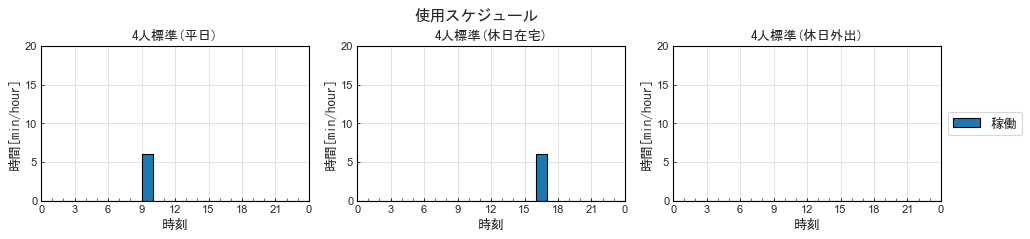

In [9]:
# 機器使用スケジュールの確認
plot_hourly_bar_chart('使用スケジュール', 
                      Schedule['4p_standard'], 
                      '4人標準',
                      {'opg':'稼働'},
                       '時間[min/hour]',  0, 20, 5, 1/60)

### 付録1：サンプルコード

4人標準世帯の標準条件について、サンプルコードを示す。

In [10]:
def get_spec(app_type):
    '''機器仕様を取得する'''
    # app_type：機器タイプ
    
    # 機器仕様の取得
    try:
        spec = Spec[app_type]
    except:
        raise Exception('機器タイプの入力に不正があります。')     
    
    Prtd_opg = spec['Prtd_opg']
    
    return Prtd_opg

Example:

In [11]:
ex_Prtd_opg = get_spec('Iron00')
ex_Prtd_opg

1400

In [12]:
def get_dt(time_use_type, time_of_day, schedule_name):
    '''機器使用スケジュールを取得する'''
    # time_use_type：['Weekdays', 'Holidays_st', 'Holidays_go']
    # time_of_day：時刻（0-23）
    # schedule_name：スケジュール名
     
    # スケジュールの取得
    try:
        schedule_set = Schedule[schedule_name][time_use_type]
    except:
        raise Exception('スケジュール名の入力に不正があります。')    
               
    # 動作状態のタイプ
    app_status_types = list(schedule_set)
    
    # 動作状態ごとの継続時間[s]の取得
    for i, app_status_type in enumerate(app_status_types):
        if app_status_type == 'opg':
            dt_opg = schedule_set[app_status_type][time_of_day]
        else:
            raise Exception
            
    # 時間超過の確認
    check_duration([dt_opg]) 
    
    return dt_opg

Example:

In [13]:
ex_dt_opg = get_dt('Weekdays', 9, '4p_standard')
ex_dt_opg

360

In [14]:
def calc_EE_opg(dt_opg, p_opg):
    '''稼働時における消費電力量[Wh]を計算する'''
    # dt_opg：単位時間における継続時間の合計[s]
    # p_opg：消費電力[W]
    
    return EE_opg(dt_opg, p_opg)

Example:

In [15]:
ex_EE_opg = calc_EE_opg(ex_dt_opg, ex_Prtd_opg)
ex_EE_opg

140.0

In [16]:
def calc_EE_app(EE_opg):
    '''稼働時における消費電力量[Wh]を計算する'''
    # EE_opg：稼働時における消費電力量[Wh]
    
    return EE_app(EE_opg)

Example:

In [17]:
ex_EE_app = calc_EE_app(ex_EE_opg)
ex_EE_app

140.0

In [18]:
def calc_EE_Iron_verP4(time_use_type, time_of_day, app_type, schedule_name):
    '''アイロンの単位時間当たりの消費電力量を計算する（ver自立P4）'''
    # time_use_type：['Weekdays', 'Holidays_st', 'Holidays_go']
    # time_of_day：時刻（0-23） 
    # app_type：機器タイプ  
    # schedule_name：スケジュール名 
    
    # 機器使用スケジュール[s]を取得
    dt_opg = get_dt(time_use_type, time_of_day, schedule_name)
    
    # 機器仕様を取得
    Prtd_opg = get_spec(app_type)
    
    # 稼働時における消費電力量[Wh]を計算
    EE_opg = calc_EE_opg(dt_opg, Prtd_opg)
    
    # 消費電力量[Wh]を計算
    EE_app = calc_EE_app (EE_opg)
    
    return EE_app, EE_opg

Example:

In [19]:
ex_EE_Iron = calc_EE_Iron_verP4('Weekdays', 9, 'Iron00', '4p_standard')
ex_EE_Iron

(140.0, 140.0)

### 付録2：サンプルコードによる時刻別消費電力量の計算例

4人標準世帯の標準条件に対して、サンプルコードにより平日、休日在宅、休日外出の時刻別消費電力量を計算した結果を示す。

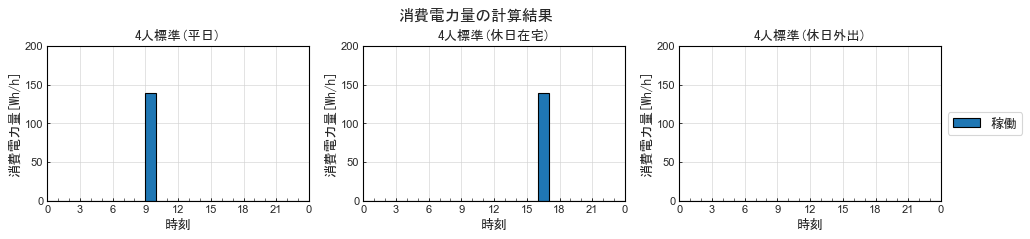

In [20]:
# 消費電力量の計算
EE_results, EE_opg_results = np.vectorize(calc_EE_Iron_verP4)([['Weekdays'], ['Holidays_st'], ['Holidays_go']], 
                                                              np.arange(24), 
                                                              'Iron00', 
                                                              '4p_standard')

# 消費電力量の計算結果
EE_results = {
    '4p_standard' : {
        'Weekdays':{'opg' : EE_opg_results[0]},  
        'Holidays_st':{'opg' : EE_opg_results[1]}, 
        'Holidays_go':{'opg' : EE_opg_results[2]}
    }
}

# 消費電力量の計算結果のグラフ
plot_hourly_bar_chart('消費電力量の計算結果', 
                      EE_results['4p_standard'], 
                      '4人標準',
                      {'opg':'稼働'},
                       '消費電力量[Wh/h]',  0, 200, 50, 1)

### 付録3：サンプルコードによる年間消費電力量の計算例

4人標準世帯の標準条件に対して、サンプルコードにより年間消費電力量を計算した結果を示す。

In [21]:
def calc_annual_EE_app(app_type, schedule_name):
    '''年間消費電力量[Wh/year]を計算する'''
    # app_type：機器タイプ  
    # schedule_name：スケジュール名  

    def calc_daily_EE_app(schedule, app_type, schedule_name):
        '''1日あたりの消費電力量[Wh/day]を計算する'''
        hourly_EE_app = [ calc_EE_Iron_verP4(schedule, t, app_type, schedule_name)[1] for t in range(0, 24, 1) ]
        return sum( hourly_EE_app )
    
    daily_EE_app = [ calc_daily_EE_app(schedule, app_type, schedule_name) for schedule in get_calendar() ]
    return sum( daily_EE_app )

In [22]:
# 年間消費電力量[kWh/year]：居間
ex_annual_EE_app = calc_annual_EE_app('Iron00', '4p_standard')
print('年間消費電力量：' + str(ex_annual_EE_app/1000) + ' kWh/年')

年間消費電力量：46.9 kWh/年
